In [ ]:
#ESSENTIAL LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout


#DATA PROCESSING


In [ ]:
#Read data
data_dir="/content/MSN.csv"
data_fr=pd.read_csv(data_dir)
data_copy=data_fr
#About data
print(data_fr.info())
#Check NaN data in each column
print(data_fr.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB
None
Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64


In [ ]:
#Preprocess data
del data_fr['Ticker']
del data_fr['Open Interest']
data_fr['Date/Time']=pd.to_datetime(data_fr['Date/Time'])
data_fr=data_fr.sort_values(by='Date/Time')
data_fr=data_fr.set_index('Date/Time')
data_fr=data_fr[['Open','High','Low','Volume','Close']]
data_fr=data_fr.iloc[:50000,:]
data_fr


,Open,High,Low,Volume,Close
Date/Time,,,,,
2017-12-25 09:15:00,73.1,73.1,73.1,4210,73.1
2017-12-25 09:16:00,73.0,73.0,73.0,5000,73.0
2017-12-25 09:18:00,73.5,73.5,73.5,210,73.5
2017-12-25 09:20:00,73.2,73.5,73.1,2050,73.1
2017-12-25 09:21:00,73.0,73.0,73.0,1380,73.0
...,...,...,...,...,...
2019-03-07 10:33:00,89.8,89.9,89.8,2200,89.9
2019-03-07 10:34:00,89.9,90.0,89.9,280,90.0
2019-03-07 10:35:00,90.0,90.0,90.0,210,90.0


#PLOT PRICE OF STOCK


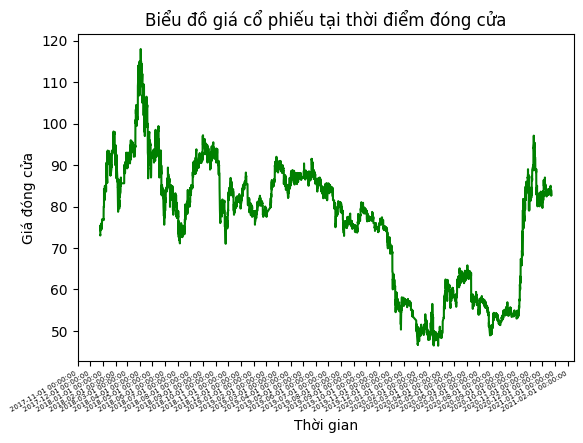

In [ ]:
#Plot movement of stock
time=(data_copy['Date/Time'])
time=[datetime.strptime(str(timestamp),"%Y-%m-%d %H:%M:%S") for timestamp in time]
close=(data_copy['Close'])
plt.plot(time,close, color='green')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.xticks(fontsize='5')
plt.title("Biểu đồ giá cổ phiếu tại thời điểm đóng cửa")
plt.xlabel("Thời gian")
plt.ylabel("Giá đóng cửa")
plt.show()

#MAKE TRAIN SET , TEST SET

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
n_train_rows=int(0.8*data_fr.shape[0])
train=data_fr.iloc[:n_train_rows,:]
test=data_fr.iloc[n_train_rows:,:]
training_set_scaled=scaler.fit_transform(train.values)
testing_set_scaled=scaler.fit_transform(test.values)
print(training_set_scaled.shape)
print(testing_set_scaled.shape)

(40000, 5)
(10000, 5)


In [ ]:
def create_dataset(dataset,n_step):
  dataX,dataY=[],[]
  for i in range(n_step,len(dataset)):
    dataX.append(dataset[i-n_step:i,:])
    dataY.append(dataset[i])
  return np.array(dataX),np.array(dataY)

n_step=24*60 #60m*24h
x_train,y_train=create_dataset(training_set_scaled,n_step=n_step)
x_test,y_test=create_dataset(testing_set_scaled,n_step=n_step)
print(x_train.shape)
print(y_train.shape)


(38560, 1440, 5)
(38560, 5)


#MODEL LSTM FOR PREDICTION


In [ ]:
model=Sequential()
model.add(LSTM(units=64,return_sequences=True,input_shape=(60*24,5)))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(units=5))
model.compile(loss='mse',optimizer='adam')
history=model.fit(x_train,y_train,batch_size=128,epochs=10)

Epoch 1/10
302/302 [==============================] - 32s 87ms/step - loss: 0.0098
Epoch 2/10
302/302 [==============================] - 28s 92ms/step - loss: 0.0030
Epoch 3/10
302/302 [==============================] - 27s 91ms/step - loss: 0.0020
Epoch 4/10
302/302 [==============================] - 26s 87ms/step - loss: 0.0014
Epoch 5/10
302/302 [==============================] - 26s 87ms/step - loss: 0.0011
Epoch 6/10
302/302 [==============================] - 26s 87ms/step - loss: 8.7244e-04
Epoch 7/10
302/302 [==============================] - 26s 86ms/step - loss: 7.4682e-04
Epoch 8/10
302/302 [==============================] - 26s 86ms/step - loss: 6.9687e-04
Epoch 9/10
302/302 [==============================] - 26s 86ms/step - loss: 6.5048e-04
Epoch 10/10
302/302 [==============================] - 28s 94ms/step - loss: 6.3340e-04


#PLOT THE PREDICTION

268/268 [==============================] - 10s 37ms/step


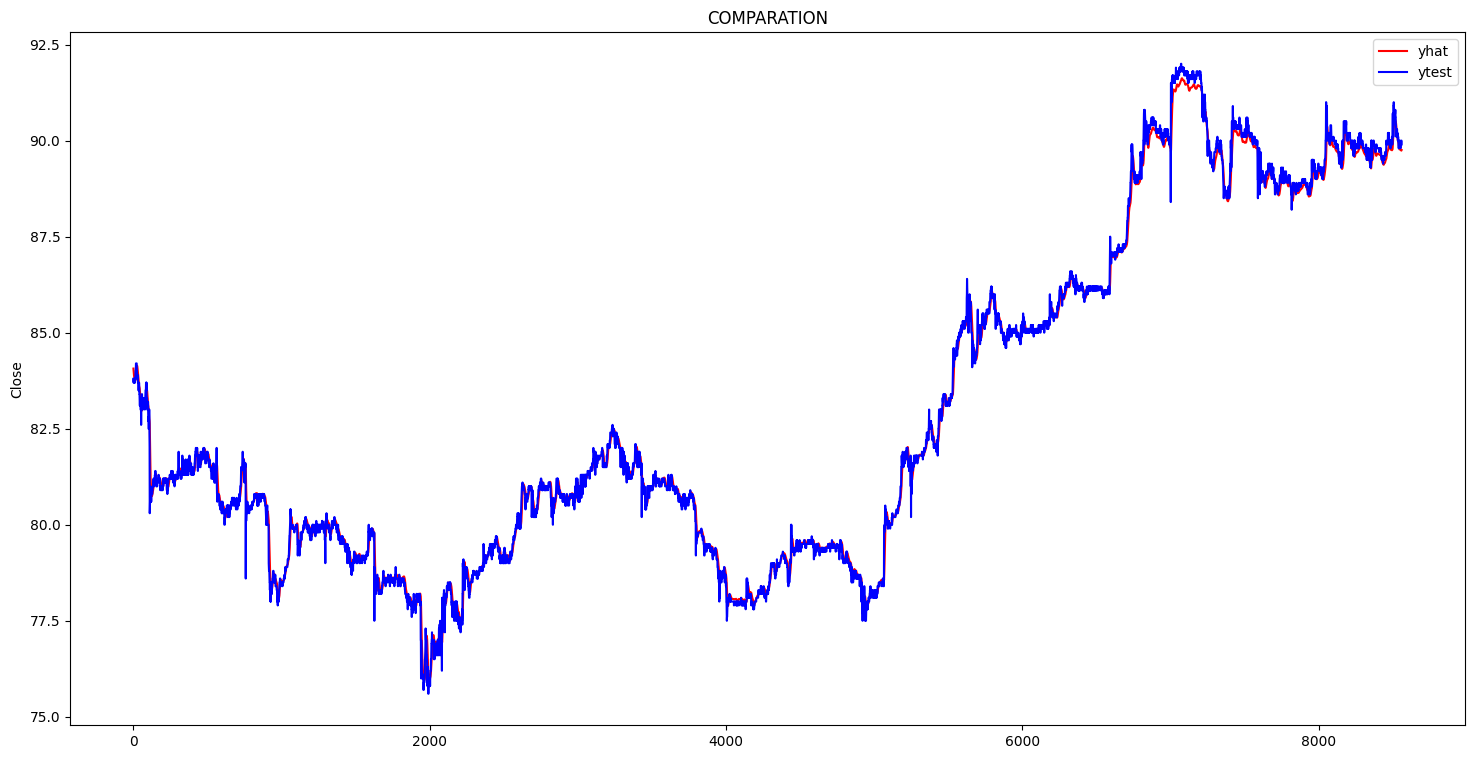

In [ ]:
y_test=test[60*24:].reset_index(drop=True)
y_hat=model.predict(x_test)
y_hat=scaler.inverse_transform(y_hat)
plt.figure(figsize=(18,9))
plt.plot(y_hat[:,0],color="red",label='yhat')
plt.plot(y_test['Close'],color="blue",label='ytest')
plt.title("COMPARATION")
plt.ylabel("Close")
plt.legend()
plt.show()


#PREDICT PRICE OF STOCK AT ONE MOMENT

In [ ]:
#Lấy dữ liệu ngày 7/3/2019 lúc 10:39
x_pred=[[[90,90,89.9,89.9,2210]]]
x=np.array(x_pred)
y_pred=model.predict(x_pred)
y_pred=scaler.inverse_transform(y_pred)
print("GIÁ CỔ PHIẾU DỰ ĐOÁN THỜI ĐIỂM TIẾP THEO : {}".format(y_pred[0][0]))


1/1 [==============================] - 0s 33ms/step
GIÁ CỔ PHIẾU DỰ ĐOÁN THỜI ĐIỂM TIẾP THEO : 85.3880844116211
